In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import keras
import tensorflow
import sklearn
from matplotlib import pyplot as plt
import sys
import surfboard
from surfboard.feature_extraction_multiprocessing import extract_features

Using TensorFlow backend.


In [2]:
#Misc. adjustments
pd.set_option('max_colwidth', 200)

In [3]:
#Listing files
filelist = os.listdir("Source/vox")

#Read files into pandas
source = pd.DataFrame(filelist)
#Rename file name column
source = source.rename(columns={0:'file'})
#Filter out DS files from macOS
source = source[source.file != ".DS_Store"]
#Reset index
source = source.reset_index(drop = True)

#Extraction of variables from filenames
speaker_id = []
condition = []
index = []

for i in range (0, len(source)):
    id = source["file"][i][0:2]
    con = source["file"][i][3]
    indx = source["file"][i][5:7]
    
    if id[0:1] == "0":
        speaker_id.append(id[1])
    else:
        speaker_id.append(id)
    
    if indx[0:1] == "0":
        index.append(indx[1])
    else:
        index.append(indx)
    
    condition.append(con)
    
#Adding variables to dataframe
source["id"] = speaker_id
source["condition"] = condition
source["indx"] = index

source.head()

,file,id,condition,indx
0,08-2-09.wav,8,2,9
1,10-2-06.wav,10,2,6
2,11-2-12.wav,11,2,12
3,11-2-06.wav,11,2,6
4,10-2-12.wav,10,2,12


In [16]:
#Create training & valuation dataframes
def create_sets(subjects, n_train, n_val, conditions):
    train_set = pd.DataFrame()
    val_set = pd.DataFrame()
    selection = subjects

    for i in selection:
        tmp_train = source[(source.id==str(i)) & (source.condition==conditions[0])]
        tmp_train = tmp_train.sample(n_train)
        train_set = train_set.append(tmp_train)
        debug1 = tmp_train
        ind = tmp_train["indx"].tolist()
        
        tmp_val = source[(source.id==str(i)) & (source.condition==conditions[1])]
        tmp_val2 = tmp_val[tmp_val["indx"].isin(ind) == False]
        debug2 = tmp_val2
        val_set = val_set.append(tmp_val2.sample(n_val))


    train_set = train_set.reset_index()
    train_set.file = os.path.join(sys.path[0], "Source/vox/") + train_set.file 
    val_set = val_set.reset_index()
    val_set.file = os.path.join(sys.path[0], "Source/vox/") + val_set.file 

    train_files = train_set.file.tolist()
    val_files = val_set.file.tolist()
    
    return train_set, val_set, train_files, val_files, debug1, debug2

In [5]:
#Feature extraction function using surfboard
def feature_extract(files):
    features = surfboard.feature_extraction_multiprocessing.extract_features_from_paths(files, ["mfcc", 'f0_statistics', 'formants'], statistics_list=['mean'], sample_rate=44100, num_proc=4)
    np.array(features)
    return features

In [6]:
#Pre-Processing
def processing(X_train, X_val, train_set, val_set):
    y_train = np.array(train_set["id"])
    y_val = np.array(val_set["id"])
    
    from sklearn.preprocessing import LabelEncoder
    from keras.utils.np_utils import to_categorical
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_val = to_categorical(lb.fit_transform(y_val))
    
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_val = ss.transform(X_val)
    #X_test = ss.transform(X_test)
    
    return y_train, y_val, X_train, X_val

In [7]:
#Model
def build_model(n_speakers):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.callbacks import EarlyStopping
    model = Sequential()
    model.add(Dense(19, input_shape=(19,), activation = 'relu'))
    #model.add(Dropout(0.1))
    model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(128, activation = 'relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(6, activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
    
    return model, early_stop


In [8]:
#Train Neural Network
def train_model(model, early_stop, log=0, graph=0):
    history = model.fit(X_train, y_train, batch_size=20, epochs=100,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stop], verbose = log)
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    if graph == 1:
        # Check train accuracy and validation accuracy over epochs.
        plt.figure(figsize=(12, 8))# Generate line plot of training, testing loss over epochs.
        plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
        plt.plot(val_accuracy, label='Validation Accuracy', color='orange')# Set title
        plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
        plt.xlabel('Epoch', fontsize = 18)
        plt.ylabel('Categorical Crossentropy', fontsize = 18)
        plt.xticks(range(0,100,5), range(0,100,5))
        plt.legend(fontsize = 18);
    
    return val_accuracy

            file  id condition indx
48   11-0-11.wav  11         0   11
16   11-0-16.wav  11         0   16
30   11-0-14.wav  11         0   14
15   11-0-02.wav  11         0    2
68   11-0-12.wav  11         0   12
36   11-0-01.wav  11         0    1
79   11-0-13.wav  11         0   13
76   11-0-07.wav  11         0    7
263  11-0-20.wav  11         0   20
52   11-0-10.wav  11         0   10
69   11-0-06.wav  11         0    6
35   11-0-15.wav  11         0   15
264  11-0-08.wav  11         0    8
8    11-0-03.wav  11         0    3
292  11-0-19.wav  11         0   19
250  11-0-09.wav  11         0    9
            file  id condition indx
26   11-2-05.wav  11         2    5
41   11-2-04.wav  11         2    4
63   11-2-17.wav  11         2   17
247  11-2-18.wav  11         2   18


Extracting features from paths...: 100%|██████████| 24/24 [00:03<00:00,  6.02it/s]


            file  id condition indx
35   11-0-15.wav  11         0   15
292  11-0-19.wav  11         0   19
263  11-0-20.wav  11         0   20
68   11-0-12.wav  11         0   12
277  11-0-18.wav  11         0   18
15   11-0-02.wav  11         0    2
48   11-0-11.wav  11         0   11
69   11-0-06.wav  11         0    6
52   11-0-10.wav  11         0   10
264  11-0-08.wav  11         0    8
76   11-0-07.wav  11         0    7
16   11-0-16.wav  11         0   16
5    11-0-17.wav  11         0   17
8    11-0-03.wav  11         0    3
250  11-0-09.wav  11         0    9
36   11-0-01.wav  11         0    1
           file  id condition indx
21  11-2-13.wav  11         2   13
26  11-2-05.wav  11         2    5
41  11-2-04.wav  11         2    4
45  11-2-14.wav  11         2   14


Extracting features from paths...: 100%|██████████| 24/24 [00:03<00:00,  7.11it/s]


            file  id condition indx
292  11-0-19.wav  11         0   19
48   11-0-11.wav  11         0   11
76   11-0-07.wav  11         0    7
47   11-0-05.wav  11         0    5
250  11-0-09.wav  11         0    9
8    11-0-03.wav  11         0    3
30   11-0-14.wav  11         0   14
52   11-0-10.wav  11         0   10
263  11-0-20.wav  11         0   20
15   11-0-02.wav  11         0    2
68   11-0-12.wav  11         0   12
36   11-0-01.wav  11         0    1
55   11-0-04.wav  11         0    4
16   11-0-16.wav  11         0   16
5    11-0-17.wav  11         0   17
35   11-0-15.wav  11         0   15
            file  id condition indx
3    11-2-06.wav  11         2    6
21   11-2-13.wav  11         2   13
247  11-2-18.wav  11         2   18
293  11-2-08.wav  11         2    8


Extracting features from paths...: 100%|██████████| 24/24 [00:03<00:00,  7.19it/s]


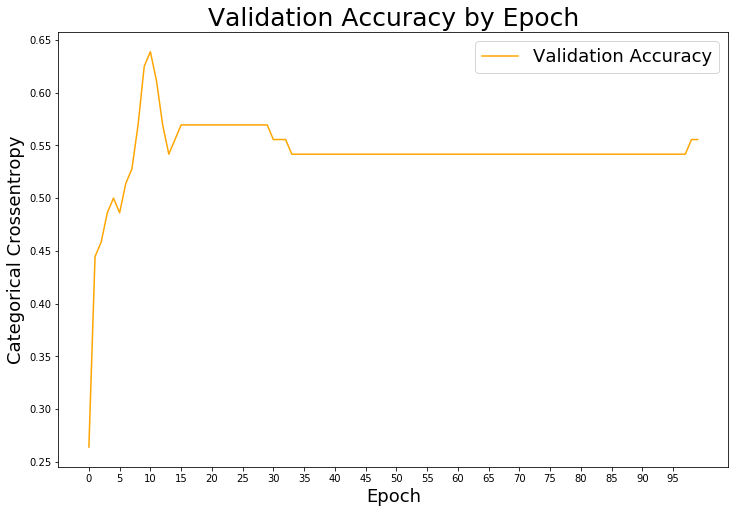

In [33]:
#Parameters
selection=(1,3,5,8,10,11)
n_train = 16
n_val = 4
conditions = ("0","2")
iterations = 3
n_speakers = len(selection)
log = 0
graph = 0

results = []

for i in range(iterations):
    #Creating sets
    [train_set, val_set, train_files, val_files, debug1, debug2] = create_sets(selection, n_train, n_val, conditions)
    print(debug1)
    print(debug2)
    #Extract features
    X_train = feature_extract(train_files)
    X_val = feature_extract(val_files)

    #Pre-Processing
    [y_train, y_val, X_train, X_val] = processing(X_train, X_val, train_set, val_set)

    #Build model
    [model, early_stop] = build_model(n_speakers)

    #Train
    result = train_model(model, early_stop, log, graph)
    results.append(result)

#Sum accuracy from all runs
sum_results = [0] * len(results[0])
for i in range (0, len(results)):
    sum_results = np.add(sum_results, results[i])

#Take average of accuracy from all runs
avg_results = [x / len(results) for x in sum_results]

# Check average accuracy
plt.figure(figsize=(12, 8))# Generate line plot of training, testing loss over epochs.
plt.plot(avg_results, label='Validation Accuracy', color='orange')# Set title
plt.title('Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);